# Livrable 2 - Image processing

## The subject
The goal is to process a set of photographs by denoising them in order to make them better processable by Machine Learning algorithms. In this Jupyter notebook we will explain the pre-processing steps. The algorithms will rely on convolutional auto-encoders, and apply them to improve the image quality.

## Import

### Disable Tensorflow's warnings

In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
run_dir = 'tf/'

In [3]:
import tensorflow as tf
import numpy as np
import fidle
from skimage.util import random_noise
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from matplotlib import pyplot as plt

2022-10-14 09:54:49.013345: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Global Variables

In [4]:
BATCH_SIZE: int = 64
IMG_HEIGHT: int = 228
IMG_WIDTH: int = 228
EPOCHS: int = 10
DATASET_PATH: str = run_dir + 'data_ae'

## Load Dataset

In [12]:

def noisy_gauss(img):
    new_data = np.copy(img)
    for i, image in enumerate(new_data):
        fidle.utils.update_progress('Add noise : ', i + 1, len(img), verbosity=1)
        image = random_noise(image, mode='gaussian', mean=0, var=0.3)
        image = random_noise(image, mode='s&p', amount=0.2, salt_vs_pepper=0.5)
        image = random_noise(image, mode='poisson')
        image = random_noise(image, mode='speckle', mean=0, var=0.1)
        new_data[i] = image
    return new_data


def salt_and_pepper(image, prob_salt=0.1, prob_pepper=0.1):
    random_values = tf.random.uniform(shape=image[0, ..., -1:].shape)
    image = tf.where(random_values < prob_salt, 1., image)
    image = tf.where(1 - random_values < prob_pepper, 0., image)
    return image


ds = tf.data.Dataset.from_tensor_slices(run_dir + 'data_ae/training',
                                        image_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=BATCH_SIZE
                                        ).batch(1).map(salt_and_pepper)

result_image = next(iter(ds))

plt.imshow(result_image[0])
plt.show()
"""""
# Train
train_data = tf.keras.utils.image_dataset_from_directory(run_dir + 'data_ae/training',
                                                         image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=BATCH_SIZE)
# Train noisy
train_data_noisy = train_data + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)

# Test
test_data = tf.keras.utils.image_dataset_from_directory(run_dir +'data_ae/validation',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Test noisy
test_data_noisy = noisy_gauss(test_data)

# Normal data generator
normal_datagen = ImageDataGenerator(
    rescale=1. / 255,
    data_format="channels_last",
    validation_split=0.20
)

# Noisy data generator
noisy_datagen = ImageDataGenerator(
    preprocessing_function=noisy_gauss,
    data_format="channels_last",
    validation_split=0.20
)

# Train
train_generator = normal_datagen.flow_from_directory(
    DATASET_PATH,
    subset='training',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
)

# Train noisy
train_noisy_generator = noisy_datagen.flow_from_directory(
    DATASET_PATH,
    subset='training',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
)

# Test
test_generator = normal_datagen.flow_from_directory(
    DATASET_PATH,
    subset='validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
)

# Test noisy
test_noisy_generator = noisy_datagen.flow_from_directory(
    DATASET_PATH,
    subset='validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
)
"""""

AttributeError: type object 'DatasetV2' has no attribute 'image_dataset_from_directory'

### Get data from generator and convert numpy array do tensorflow dataset

In [24]:
train_data_noisy = train_noisy_generator.next()
train_data = train_generator.next()
test_data_noisy = test_noisy_generator.next()
test_data = test_generator.next()

Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [########################################] 100.0% of 228
Add noise :      [####################

## Implementation of functions to display the images.

In [25]:
def display_single_image(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")


def display_image(x, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(x[i].reshape(IMG_HEIGHT, IMG_WIDTH, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Add noise :      [########################################] 100.0% of 640


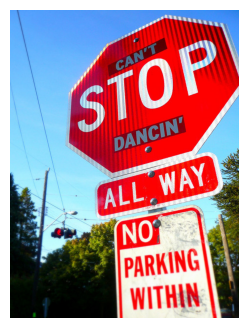

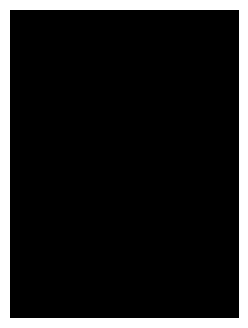

In [26]:
#Print an image of both datasets for testing
img = image.image_utils.load_img(DATASET_PATH + '/training/photo_0003.jpg')

display_single_image(np.array(img))
display_single_image(noisy_gauss(np.array(img)))

Training set


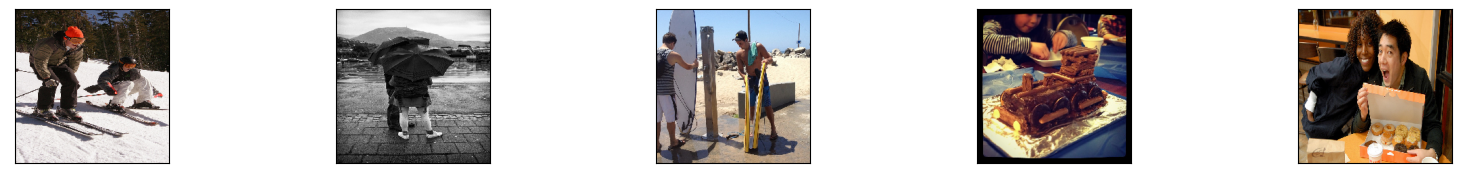

Noisy training set


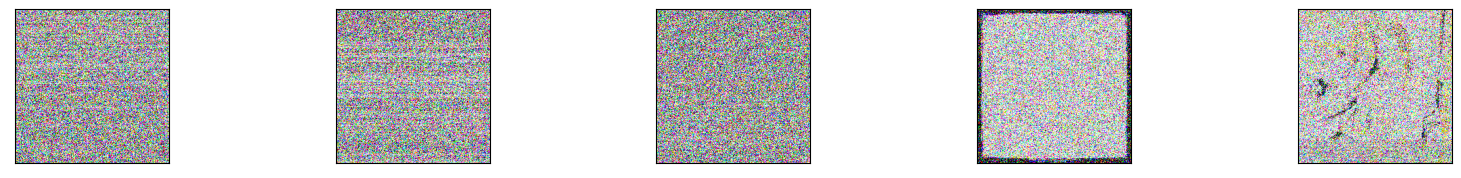

Validation Set


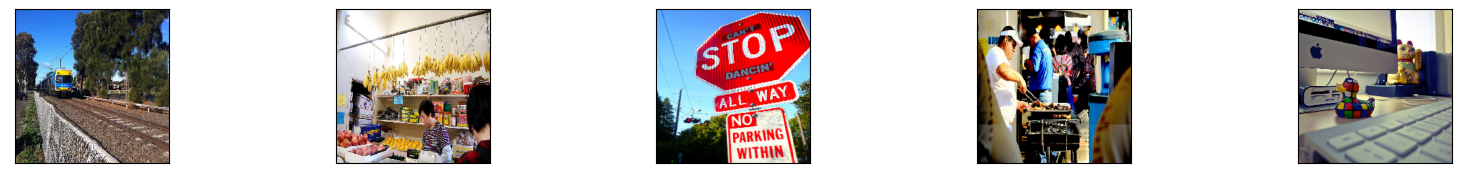

Noisy validation set


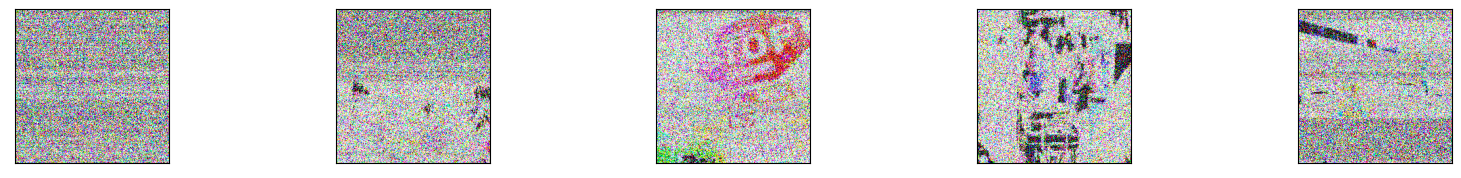

In [27]:
print("Training set")
display_image(train_data, 5)
print("Noisy training set")
display_image(train_data_noisy, 5)
print("Validation Set")
display_image(test_data, 5)
print("Noisy validation set")
display_image(test_data_noisy, 5)

## Encoder

In [28]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

encoder = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)

## Decoder

In [29]:
decoder = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(
    encoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(
    decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')(
    decoder)

## Auto encoder

In [30]:
auto_encoder = tf.keras.Model(inputs, decoder, name="auto_encoder")

auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

### Load datasets in cache to optimize training time

In [31]:
x_train_noisy = tf.data.Dataset.from_tensor_slices(train_data_noisy)
x_train = tf.data.Dataset.from_tensor_slices(train_data)
x_test_noisy = tf.data.Dataset.from_tensor_slices(test_data_noisy)
x_test = tf.data.Dataset.from_tensor_slices(test_data)

AUTOTUNE = tf.data.AUTOTUNE
x_train_noisy = x_train_noisy.cache().prefetch(buffer_size=AUTOTUNE)
x_train = x_train.cache().prefetch(buffer_size=AUTOTUNE)

## Save the best model

In [32]:
filename = run_dir + "models/best_model.h5"
callback_best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

## Train the model

In [ ]:
auto_encoder.summary()

history = auto_encoder.fit(train_data_noisy, train_data,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=1,
                           shuffle=True,
                           validation_data=(test_data, test_data_noisy),
                           #callbacks=[callback_best_model]
                           )

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 228, 228, 256)     7168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 114, 114, 256)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 114, 114, 128)     295040    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 57, 57, 128)      0         
 2D)                                                             
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 57, 57, 128)     